# 1. Loading data
I'll just load a small subset of the data for more speedy testing

In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Load subset of the training data
X_train = pd.read_csv('/Users/mlx/Downloads/Document/talking_data/train_2m.csv', parse_dates=['click_time'])

# Show the head of the table
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,123896,25,1,25,259,2017-11-07 13:32:55,NaN,0
1,38732,2,1,22,237,2017-11-07 02:57:07,NaN,0
2,135586,3,1,19,280,2017-11-07 03:14:46,NaN,0
3,189070,3,1,13,173,2017-11-09 10:48:37,NaN,0
4,89669,1,1,19,135,2017-11-09 08:02:33,NaN,0


# 2. Creating Features
## 2.1 Extracting time information
First extract day, minute, hour, second from the click_time. 

In [2]:
X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,123896,25,1,25,259,2017-11-07 13:32:55,NaN,0,7,13,32,55
1,38732,2,1,22,237,2017-11-07 02:57:07,NaN,0,7,2,57,7
2,135586,3,1,19,280,2017-11-07 03:14:46,NaN,0,7,3,14,46
3,189070,3,1,13,173,2017-11-09 10:48:37,NaN,0,9,10,48,37
4,89669,1,1,19,135,2017-11-09 08:02:33,NaN,0,9,8,2,33


## 2.2 Group-By-Aggregation
There are a lot of groupby -> count()/var()/mean() etc. feature engineering in the kernels I've checked out, so of course those have to be added as well :)

In [3]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'},    
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}-{}-{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
        X_train = X_train.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

X_train.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nunique
Grouping by ['app'], and aggregating channel with nunique


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip-nunique-channel,ip-nunique-app,ip_day-nunique-hour,ip_app-nunique-os,ip-nunique-device,app-nunique-channel,ip_device_os-nunique-app,ip_device_os-cumcount-app,ip-cumcount-app,ip-cumcount-os
0,123896,25,1,25,259,2017-11-07 13:32:55,NaN,0,7,13,...,65,24,14,2,1,1,3,0,0,0
1,38732,2,1,22,237,2017-11-07 02:57:07,NaN,0,7,2,...,61,18,15,8,1,22,9,0,0,0
2,135586,3,1,19,280,2017-11-07 03:14:46,NaN,0,7,3,...,6,5,6,3,1,38,2,0,0,0
3,189070,3,1,13,173,2017-11-09 10:48:37,NaN,0,9,10,...,42,17,14,8,2,38,10,0,0,0
4,89669,1,1,19,135,2017-11-09 08:02:33,NaN,0,9,8,...,46,18,13,1,3,28,13,0,0,0


## 2.3 Confidence Rates for is_attributed
My thought is that some ips, apps, devices, etc. might have higher frequencies of is_attributed, and I wish to add that information, i.e. I'm calculating the following "attributed rates":

\begin{equation}
\text{P}\,\text{(is_attributed}\,\,|\,\,\text{category)}
\end{equation}

or in some cases two- or multiple-paired combinations:

\begin{equation}
\text{P}\,\text{(is_attributed}\,\,|\,\,\text{category_1, category_2)}
\end{equation}

The danger of this is that if a given category-combination has very few clicks, then the statistical significance of above equations cannot be trusted. Therefore I'll be weighing the rates by the following confidence rates:

\begin{equation}
    \text{conf}_{\text{is_attributed}} = \frac{\log(\text{views}_{\text{category_1}})}{\log(100000)}
\end{equation}

where the value 100000 has been chosen arbitrarily to such that if a given category has 1000 views, then it gets a confidence weight of 60%, if it has 100 views then onfly a confidence weight of 40% etc.

In [4]:
valid_size = len(X_train)//10
val_df = X_train[:valid_size]
train_df = X_train[valid_size:]

In [5]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ###############
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ###############
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = train_df.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    train_df = train_df.merge(
        group_object['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'is_attributed': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
train_df.head()

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate. Group Max /Mean / Median / Min: 12113 / 18.74 / 5.0 / 1
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate. Group Max /Mean / Median / Min: 330138 / 5787.78 / 12.0 / 1
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate. Group Max /Mean / Median / Min: 1697263 / 3061.22 / 1.0 / 1
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate. Group Max /Mean / Median / Min: 429115 / 7894.74 / 19.0 / 1
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate. Group Max /Mean / Median / Min: 146245 / 10404.62 / 2510.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'channel'].
   Saving to: app_channel_confRate. Group Max /Mean / Median / Min: 140671 / 2496.53 / 30.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'os'].
   Saving to: app_os_confRate. Group Max /Mean / Median / Mi

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,app_confRate,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate
0,320681,9,1,1,489,2017-11-09 01:12:45,NaN,0,9,1,...,0.001027,0.001799,0.001049,0.000436,0.001122,0.000000,0.001099,0.000000,0.000439,0.001069
1,5704,12,1,8,259,2017-11-09 00:56:26,NaN,0,9,0,...,0.000098,0.001799,0.001017,0.000302,0.000033,0.000215,0.000103,0.000710,0.000336,0.001025
2,65302,6,1,22,459,2017-11-09 11:53:56,NaN,0,9,11,...,0.000036,0.001799,0.001740,0.000295,0.000000,0.000000,0.000038,0.000533,0.000303,0.001787
3,57333,9,1,41,134,2017-11-08 07:10:40,NaN,0,8,7,...,0.001027,0.001799,0.001000,0.000492,0.000635,0.000000,0.001099,0.000000,0.000512,0.001020
4,32907,12,1,6,19,2017-11-07 04:34:20,NaN,0,7,4,...,0.000098,0.001799,0.001118,0.000265,0.000308,0.000000,0.000103,0.001864,0.000266,0.001129


In [6]:
for cols in ATTRIBUTION_CATEGORIES:
    new_feature = '_'.join(cols)+'_confRate'
    
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    val_df = val_df.merge(
        train_df.groupby(cols)['is_attributed']. \
        apply(rate_calculation). \
        reset_index(). \
        rename( 
            index=str,
            columns={'is_attributed': new_feature}

        )[cols + [new_feature]],
        on=cols, how='left'
    )

In [7]:
train_df = train_df.select_dtypes(include=[np.number])
val_df = val_df.select_dtypes(include=[np.number])

# LightGBM

In [8]:
import lightgbm as lgb

def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                      feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10,
                      categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric': metrics,
        'learning_rate': 0.01,
        # 'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric': metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params,
                     xgtrain,
                     valid_sets=[xgtrain, xgvalid],
                     valid_names=['train', 'valid'],
                     evals_result=evals_results,
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10,
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics + ":", evals_results['valid'][metrics][n_estimators - 1])

    return bst1


In [9]:
target = 'is_attributed'
predictors = list(train_df.columns.values)
if 'is_attributed' in predictors:
    predictors.remove('is_attributed')
categorical = ['ip', 'app', 'device', 'os', 'channel']

In [10]:
boosting_types = ['gbdt']
lamdas = [0.01, 0.05, 0.1, 0.5]
max_depths = [2, 4, 8, -1]
min_child_samples_nums = [20, 40, 60, 100]
model_dict_v2 = {}

for bt in boosting_types:
    for lamda in lamdas:
        for max_depth in max_depths:
            for min_child_samples_num in min_child_samples_nums:
                print('********************************')
                model_name = bt + '_' + str(lamda) + '_' + str(max_depth) + '_' + str(min_child_samples_num)
                print('Now training model:', model_name)
                num_leaf = 2**max_depth-1 if max_depth!=-1 else 31
                params = {
                    'boosting_type': bt,
                    'reg_lambda': lamda,
                    'learning_rate': 0.1,
                    # 'is_unbalance': 'true', # replaced with scale_pos_weight argument
                    'num_leaves': num_leaf,  # 2^max_depth - 1
                    'max_depth': max_depth,  # -1 means no limit
                    'min_child_samples': min_child_samples_num,  # Minimum number of data need in a child(min_data_in_leaf)
                    'max_bin': 100,  # Number of bucketed bin for feature values
                    'subsample': 0.7,  # Subsample ratio of the training instance.
                    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
                    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
                    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
                    'scale_pos_weight': 99  # because training data is extremely unbalanced
                }

                bst = lgb_modelfit_nocv(params,
                                        train_df,
                                        val_df,
                                        predictors,
                                        target,
                                        objective='binary',
                                        metrics='auc',
                                        early_stopping_rounds=30,
                                        verbose_eval=True,
                                        num_boost_round=500,
                                        categorical_features=categorical)
                model_dict_v2[model_name] = bst

********************************
Now training model: gbdt_0.01_2_20
preparing validation datasets


/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/mlx/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.975697	valid's auc: 0.917146
[20]	train's auc: 0.991514	valid's auc: 0.951013
[30]	train's auc: 0.995119	valid's auc: 0.957258
[40]	train's auc: 0.996398	valid's auc: 0.960036
[50]	train's auc: 0.997013	valid's auc: 0.959821
[60]	train's auc: 0.997437	valid's auc: 0.959219
[70]	train's auc: 0.997704	valid's auc: 0.959767
Early stopping, best iteration is:
[44]	train's auc: 0.996631	valid's auc: 0.960666

Model Report
n_estimators :  44
auc: 0.960666028256
********************************
Now training model: gbdt_0.01_2_40
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.975697	valid's auc: 0.917146
[20]	train's auc: 0.991514	valid's auc: 0.951013
[30]	train's auc: 0.995119	valid's auc: 0.957258
[40]	train's auc: 0.996398	valid's auc: 0.960036
[50]	train's auc: 0.997013	valid's auc: 0.959821
[60]	train's auc: 0.997437	valid's auc: 0.959219
[70]

[80]	train's auc: 0.999493	valid's auc: 0.951928
Early stopping, best iteration is:
[52]	train's auc: 0.99932	valid's auc: 0.954634

Model Report
n_estimators :  52
auc: 0.954633821687
********************************
Now training model: gbdt_0.01_-1_40
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.998121	valid's auc: 0.916428
[20]	train's auc: 0.998672	valid's auc: 0.939688
[30]	train's auc: 0.999024	valid's auc: 0.938739
[40]	train's auc: 0.999194	valid's auc: 0.949539
[50]	train's auc: 0.999308	valid's auc: 0.950459
[60]	train's auc: 0.999378	valid's auc: 0.951579
Early stopping, best iteration is:
[34]	train's auc: 0.999088	valid's auc: 0.954363

Model Report
n_estimators :  34
auc: 0.954363242435
********************************
Now training model: gbdt_0.01_-1_60
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.998121	valid's auc: 0.916428
[20]	train's 

********************************
Now training model: gbdt_0.05_8_40
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.99896	valid's auc: 0.731434
[20]	train's auc: 0.999237	valid's auc: 0.91663
[30]	train's auc: 0.99935	valid's auc: 0.924683
[40]	train's auc: 0.999431	valid's auc: 0.942136
[50]	train's auc: 0.999485	valid's auc: 0.944392
[60]	train's auc: 0.999523	valid's auc: 0.94733
[70]	train's auc: 0.999558	valid's auc: 0.940802
[80]	train's auc: 0.999587	valid's auc: 0.940981
[90]	train's auc: 0.999618	valid's auc: 0.94403
Early stopping, best iteration is:
[60]	train's auc: 0.999523	valid's auc: 0.94733

Model Report
n_estimators :  60
auc: 0.947329601303
********************************
Now training model: gbdt_0.05_8_60
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.998928	valid's auc: 0.718246
[20]	train's auc: 0.999212	valid's auc: 0.915161
[30]	train

********************************
Now training model: gbdt_0.1_4_20
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.996023	valid's auc: 0.927247
[20]	train's auc: 0.997629	valid's auc: 0.941009
[30]	train's auc: 0.998312	valid's auc: 0.942918
[40]	train's auc: 0.998597	valid's auc: 0.95639
[50]	train's auc: 0.998793	valid's auc: 0.956552
[60]	train's auc: 0.998912	valid's auc: 0.95643
[70]	train's auc: 0.998977	valid's auc: 0.955111
Early stopping, best iteration is:
[41]	train's auc: 0.998637	valid's auc: 0.957815

Model Report
n_estimators :  41
auc: 0.957814724754
********************************
Now training model: gbdt_0.1_4_40
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.996023	valid's auc: 0.927247
[20]	train's auc: 0.997644	valid's auc: 0.940753
[30]	train's auc: 0.998269	valid's auc: 0.94192
[40]	train's auc: 0.998658	valid's auc: 0.954802
[50]	trai

[10]	train's auc: 0.975697	valid's auc: 0.917146
[20]	train's auc: 0.991514	valid's auc: 0.951013
[30]	train's auc: 0.995119	valid's auc: 0.957258
[40]	train's auc: 0.996398	valid's auc: 0.960036
[50]	train's auc: 0.997013	valid's auc: 0.959821
[60]	train's auc: 0.997436	valid's auc: 0.959219
[70]	train's auc: 0.997703	valid's auc: 0.959767
Early stopping, best iteration is:
[44]	train's auc: 0.99663	valid's auc: 0.960666

Model Report
n_estimators :  44
auc: 0.960666216851
********************************
Now training model: gbdt_0.5_2_40
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.975697	valid's auc: 0.917146
[20]	train's auc: 0.991514	valid's auc: 0.951013
[30]	train's auc: 0.995119	valid's auc: 0.957258
[40]	train's auc: 0.996398	valid's auc: 0.960036
[50]	train's auc: 0.997013	valid's auc: 0.959821
[60]	train's auc: 0.997436	valid's auc: 0.959219
[70]	train's auc: 0.997703	valid's auc: 0.959767
Early stopping, bes

[60]	train's auc: 0.999367	valid's auc: 0.945525
[70]	train's auc: 0.999437	valid's auc: 0.945056
[80]	train's auc: 0.999492	valid's auc: 0.951259
[90]	train's auc: 0.99953	valid's auc: 0.952055
[100]	train's auc: 0.999563	valid's auc: 0.952089
[110]	train's auc: 0.999596	valid's auc: 0.952367
[120]	train's auc: 0.999623	valid's auc: 0.951601
[130]	train's auc: 0.999644	valid's auc: 0.952278
Early stopping, best iteration is:
[107]	train's auc: 0.999584	valid's auc: 0.953106

Model Report
n_estimators :  107
auc: 0.953105829844
********************************
Now training model: gbdt_0.5_-1_40
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.99812	valid's auc: 0.916401
[20]	train's auc: 0.99866	valid's auc: 0.943025
[30]	train's auc: 0.999016	valid's auc: 0.944029
[40]	train's auc: 0.999181	valid's auc: 0.944724
[50]	train's auc: 0.999301	valid's auc: 0.948623
[60]	train's auc: 0.999371	valid's auc: 0.950801
[70]	train's a

In [26]:
l = []
for model in model_dict_v2:
    model_features = model.split('_')[1:]
    auc = model_dict_v2[model].best_score['valid']['auc']
    l.append(model_features + [auc])


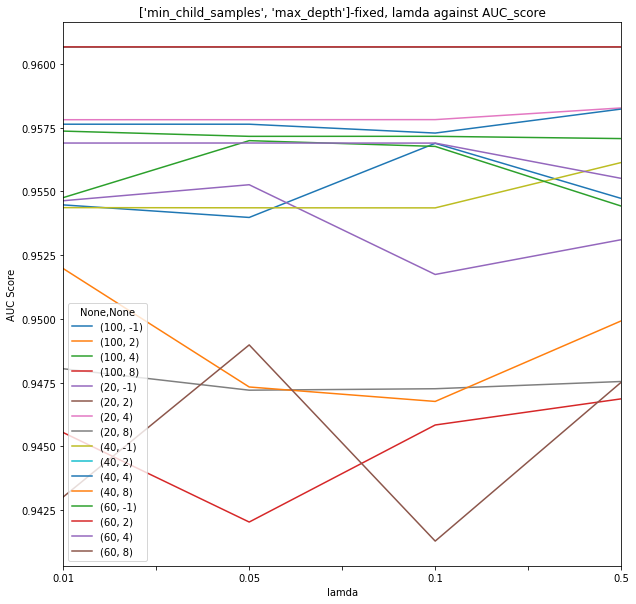

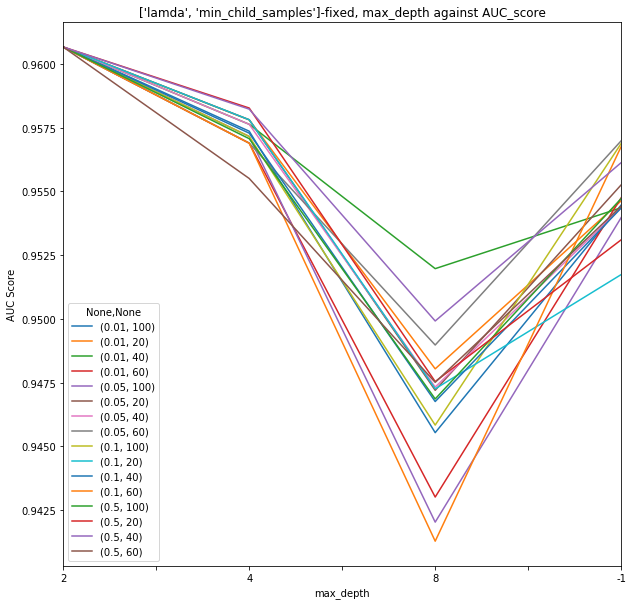

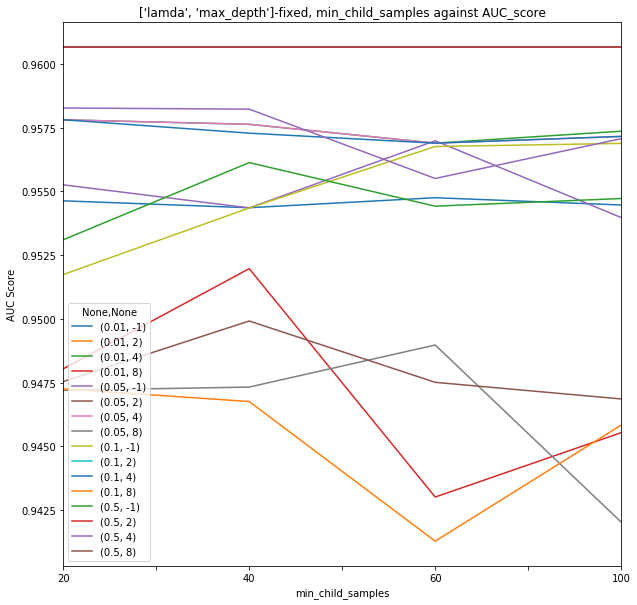

In [83]:
cols =['lamda', 'max_depth', 'min_child_samples', 'valid_auc']

for i in range(0,3):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    df = pd.DataFrame(l, columns = cols) 
    index_col = cols[i]
    group_col = list(set(cols[:3])-set([index_col]))
    df.set_index(cols[i], inplace=True)
    df.groupby(group_col)['valid_auc'].plot(legend=True)
    plt.title('{}-fixed, {} against AUC_score'.format(str(group_col), index_col))
    plt.ylabel('AUC Score')
    plt.subplots_adjust(hspace=0.3)
    fig.savefig('{}-fixed, {} against AUC_score'.format(str(group_col), index_col)+'.png', dpi=150)
    plt.show()

In [27]:
X_test['is_attributed'] = model_dict['gbdt_0.01_8_100'].predict(X_test[predictors])

In [28]:
X_test[['click_id', 'is_attributed']].to_csv('/Users/mlx/Downloads/Document/talking_data/gbdt_40features.csv', index=False)